In [4]:
import io 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds 

Word embedding
- First think about is bag of words by using 1 hot encoding but the problem is very sparse
- Another option is integer encoding, assigning a number to unique words. This option does not capture the relationship between words. This is because it forms a basis in a higher dimensional space where all of the vectors are orthogonal. When you try to perform a dot product btw vectors the value is zero, so no relationship is captured.
- Word embedding is utilizing the integer encoding but adding a transformation to another space, which captures the relationship between all the words in that space. Produce a semantic relationship.

In [5]:
#embedding_layer = layers.Embedding(1000, 5)
#result = embedding_layer(tf.constant([1,2,3]))

#print(result.numpy())

[[ 0.01398471 -0.01946988  0.04228516 -0.0445716   0.04905529]
 [ 0.0336452  -0.01535778 -0.04268111  0.00026872 -0.01091482]
 [-0.00304066 -0.03752041  0.03166851 -0.0024878   0.0162395 ]]


Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.6283 - accuracy: 0.7094 - val_loss: 0.5449 - val_accuracy: 0.8200
Epoch 2/10
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4533 - accuracy: 0.8435 - val_loss: 0.3980 - val_accuracy: 0.8700
Epoch 3/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3532 - accuracy: 0.8806 - val_loss: 0.3678 - val_accuracy: 0.8600
Epoch 4/10
2500/2500 [==============================] - 4s 1ms/step - loss: 0.3016 - accuracy: 0.8975 - val_loss: 0.2785 - val_accuracy: 0.9200
Epoch 5/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2665 - accuracy: 0.9092 - val_loss: 0.3473 - val_accuracy: 0.8750
Epoch 6/10
2500/2500 [==============================] - 4s 1ms/step - loss: 0.2438 - accuracy: 0.9180 - val_loss: 0.3207 - val_accuracy: 0.8900
Epoch 7/10
2500/2500 [==============================] - 4s 1ms/step - loss: 0.2272 - accuracy: 0.9238 - val_loss: 0.3566 - val_accuracy:

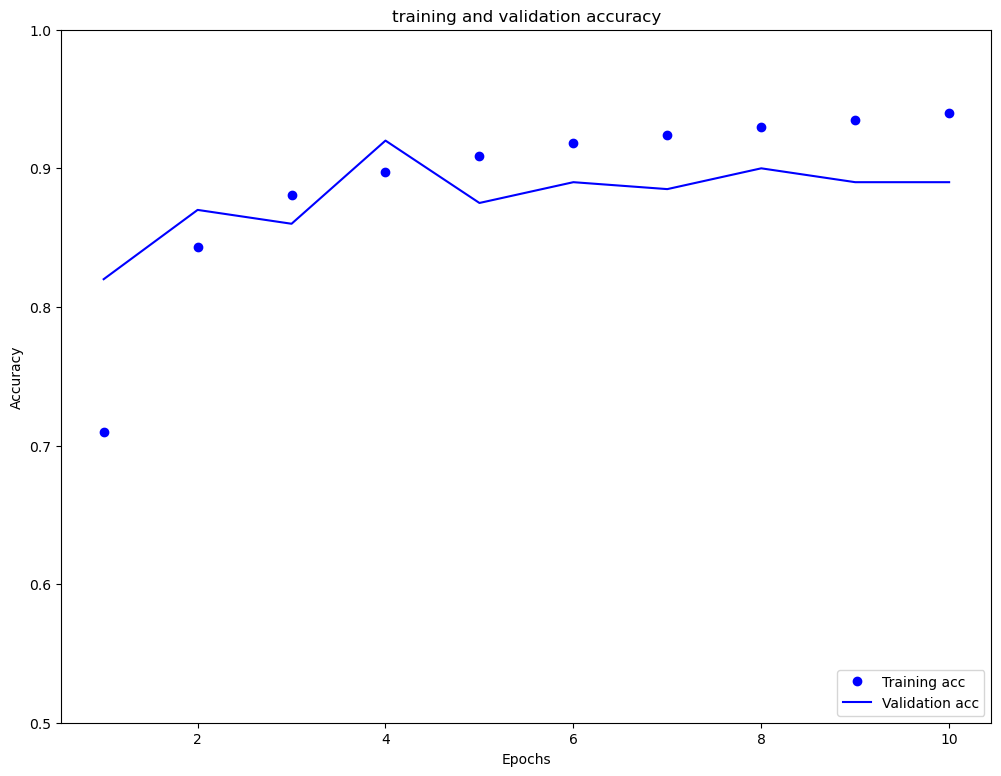

In [12]:
def get_batch_data():
    (train_data, test_data), info = tfds.load('imdb_reviews/subwords8k',
                                            split=(tfds.Split.TRAIN, tfds.Split.TEST),
                                            with_info=True, as_supervised=True)

    encoder = info.features['text'].encoder
    #print(encoder.subwords[:20])

    # Padded_shapes are used because we need to have the same length of reviews. We take the longest view and anything.
    # shorter we will append a bunch of zeros until its the same length of the longest review
    padded_shapes= ([None], ())
    train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
    test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
    
    return train_batches, test_batches, encoder

def get_model(encoder, embedding_dim = 16):
    ## Sigmoid: this layer is the probabilty the review is positive
    
    model = keras.Sequential([
                    layers.Embedding(encoder.vocab_size, embedding_dim),
                    layers.GlobalAveragePooling1D(),
                    layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

def plot_history(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,9))
    plt.plot(epochs, acc, 'bo', label= 'Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim((0.5,1))
    plt.show()

def retrieve_embedding(model, encoder):
    """ The the encoder and dump it to a tsv file where we can load into a visualizer. To Visualize the PCA 
        of our word endcoding.
    Args:
        model (_type_): _description_
        encoder (_type_): _description_
    """
    out_vectors = io.open('vecs.tsv', 'w', encoding='utf-8')
    out_metadata = io.open('meta.tsv', 'w', encoding='utf-8')
    weights = model.layers[0].get_weights()[0]
    
    for num, word in enumerate(encoder.subwords):
        vec = weights[num+1] # We want to start from one and not the padding 
        out_metadata.write(word + '\n')
        out_vectors.write('\t'.join([str(x) for x in vec]) + '\n')
    out_vectors.close()
    out_metadata.close()



train_batches, test_batches, encoder = get_batch_data()
model = get_model(encoder)
history = model.fit(train_batches, epochs=10, validation_data=test_batches,
                    validation_steps=20)

plot_history(history)
retrieve_embedding(model, encoder)

